# Data processing steps:
- Load the raw dataset or the preprocessed dataset
- random splite the loaded data into train, val, and test parts
- send the different data portion to dataloader in which the loader supports batch manipulation
- send the loaded data to particular devices, such as "cpu" or "cuda"

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# Loading MNIST

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


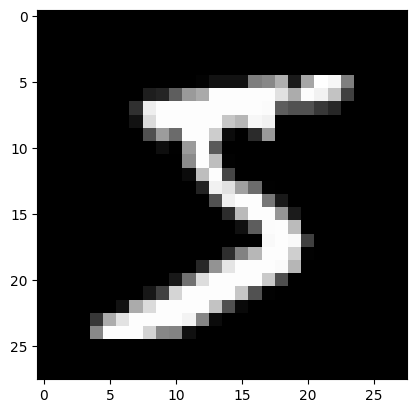

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [6]:
batch_size=128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


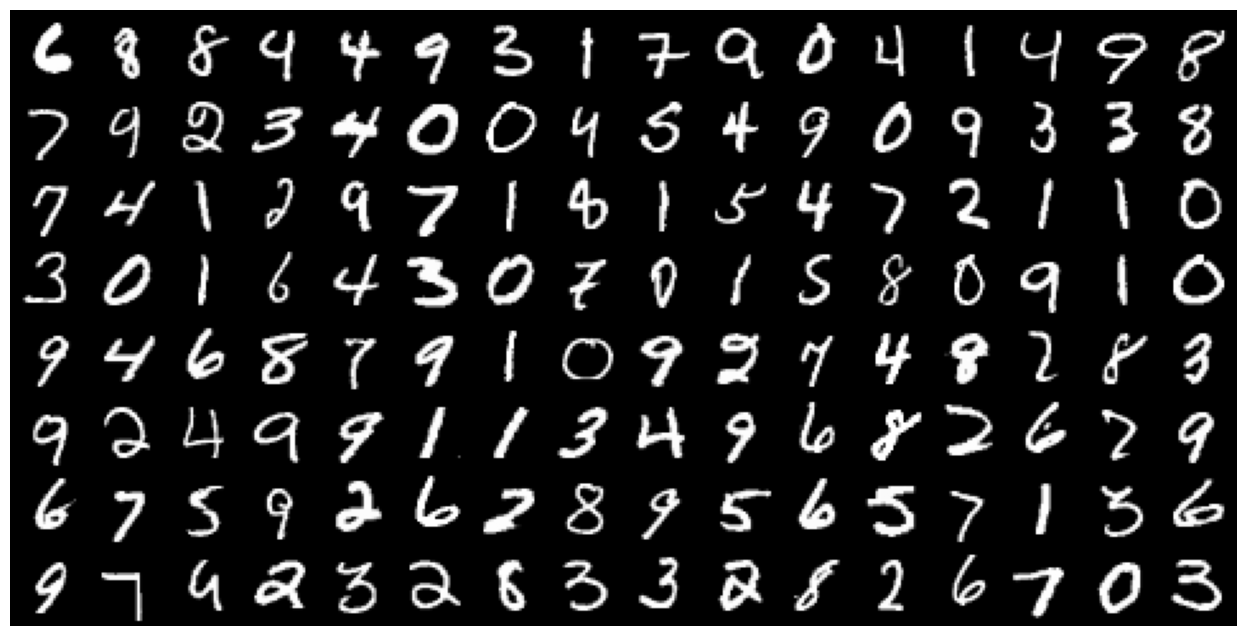

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [10]:
input_size = inputs.shape[-1]
hidden_size = 32

In [11]:
layer1 = nn.Linear(input_size, hidden_size)

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [14]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [16]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [17]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.561205267906189
min(relu_outputs): 0.0


In [18]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [19]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [20]:
inputs.shape

torch.Size([128, 784])

In [21]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3090, grad_fn=<NllLossBackward0>)

In [22]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [23]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [24]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [25]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [26]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [27]:
torch.allclose(outputs2, outputs3, 1e-3)

True

# Model  

- Diff view and reshape
- self(images) means to take the input by the class or model itself, i.e. MnistModel(input)

In [29]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [33]:
def accuracy(outputs, labels):
    """
    Count the number of correct predictions and compute the percentage of 
    correct / total number of predictions (len(preds))
    """
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [34]:
input_size = 784
hidden_size = 32
num_classes = 10

In [35]:
model = MnistModel(in_size=input_size, 
                   hidden_size=hidden_size, 
                   out_size=num_classes)

In [36]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [37]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print("Loss: ", loss.item())
    break

print("outputs.shape: ", outputs.shape)
print("sample outputs: \n", outputs[:2].data)

Loss:  2.3044416904449463
outputs.shape:  torch.Size([128, 10])
sample outputs: 
 tensor([[-0.1275,  0.1321, -0.2185,  0.1956,  0.1314,  0.1009, -0.0580, -0.1243,
          0.0837,  0.1006],
        [-0.0558,  0.2278, -0.2224,  0.1642,  0.2175,  0.1699, -0.2513, -0.1016,
          0.2154,  0.1645]])


# GPU

In [41]:
torch.cuda.is_available()

True

In [42]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

In [44]:
device = get_default_device()
device

device(type='cuda')

In [48]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)  # non-blocking - asynchronous or not

In [59]:
for images, labels in train_loader:
    print(images.shape)
    print(type(images))
    print(len(images))
    # print(images[0])
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
<class 'torch.Tensor'>
128
cuda:0


In [60]:
for images, labels in train_loader:
    for each in images:
        print(each)
        print(type(each))
        print(len(each))
        print(each.shape)
    break

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [54]:
for images, labels in train_loader:
    print(isinstance(images, (list, tuple)))
    break

False


# Device loader

In [61]:
class DeviceDataLoader():
    """
    Wrap a dataloader to move data to a device
    """
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """
        Yield a batch of data after moving it to device
        """
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """
        Return the number of batches
        """
        return len(self.dl)

In [64]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [73]:
for xb, yb in val_loader:
    print("xb.device: ", xb.device)
    print("\nxb.shape: ", xb.shape)
    print("yb.device: {0}, \nlen of yb: {1}".format(yb, len(yb)))
    break

xb.device:  cuda:0

xb.shape:  torch.Size([256, 1, 28, 28])
yb.device: tensor([6, 0, 2, 8, 3, 1, 3, 8, 1, 3, 4, 4, 4, 1, 4, 2, 2, 3, 9, 8, 2, 0, 0, 1,
        9, 1, 2, 3, 1, 2, 4, 3, 4, 8, 7, 8, 1, 1, 4, 6, 7, 5, 4, 3, 2, 9, 3, 2,
        3, 9, 2, 2, 6, 9, 8, 4, 2, 5, 3, 6, 4, 8, 3, 8, 5, 5, 2, 3, 0, 7, 0, 1,
        6, 8, 5, 2, 4, 5, 1, 6, 6, 4, 2, 2, 5, 7, 8, 8, 6, 7, 7, 1, 7, 7, 2, 8,
        5, 4, 8, 7, 3, 5, 3, 9, 6, 4, 9, 3, 2, 3, 6, 4, 2, 2, 8, 6, 9, 0, 3, 8,
        1, 3, 3, 0, 9, 5, 5, 6, 0, 0, 8, 2, 9, 3, 2, 9, 4, 8, 1, 8, 2, 0, 7, 7,
        3, 7, 5, 1, 5, 3, 8, 6, 4, 5, 8, 5, 8, 0, 8, 1, 4, 9, 1, 5, 5, 7, 6, 7,
        0, 2, 1, 8, 4, 4, 5, 2, 9, 4, 0, 9, 3, 8, 9, 8, 4, 6, 0, 3, 4, 1, 9, 7,
        6, 6, 9, 7, 8, 9, 7, 8, 9, 8, 3, 8, 6, 5, 7, 0, 0, 2, 6, 7, 7, 3, 6, 5,
        7, 2, 5, 4, 7, 9, 1, 6, 4, 3, 7, 4, 6, 8, 8, 4, 3, 9, 3, 2, 8, 7, 4, 8,
        4, 2, 7, 1, 6, 4, 6, 9, 8, 8, 7, 3, 7, 0, 3, 0], device='cuda:0'), 
len of yb: 256


# Model training

In [75]:
def evaluate(model, val_loader):
    """
    Evaluate the model's performance on the validation set
    """
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    # pass the model parameters and learning rate to SGD optimization
    optimizer = opt_func(model.parameters(), lr) 
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history
            

In [76]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [77]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.3133227825164795, 'val_acc': 0.09765625}]

In [78]:
history += fit(5, .5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2208, val_acc: 0.9330
Epoch [1], val_loss: 0.2067, val_acc: 0.9365
Epoch [2], val_loss: 0.1528, val_acc: 0.9546
Epoch [3], val_loss: 0.1330, val_acc: 0.9609
Epoch [4], val_loss: 0.1272, val_acc: 0.9625


In [79]:
history += fit(5, .1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1131, val_acc: 0.9660
Epoch [1], val_loss: 0.1106, val_acc: 0.9665
Epoch [2], val_loss: 0.1094, val_acc: 0.9687
Epoch [3], val_loss: 0.1091, val_acc: 0.9686
Epoch [4], val_loss: 0.1098, val_acc: 0.9678


Text(0.5, 1.0, 'Loss vs No. of epochs')

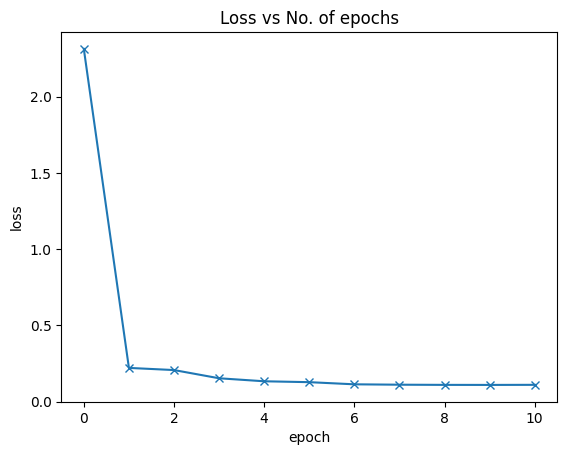

In [80]:
# plot the result
losses = [x["val_loss"] for x in history]
plt.plot(losses, "-x")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss vs No. of epochs")

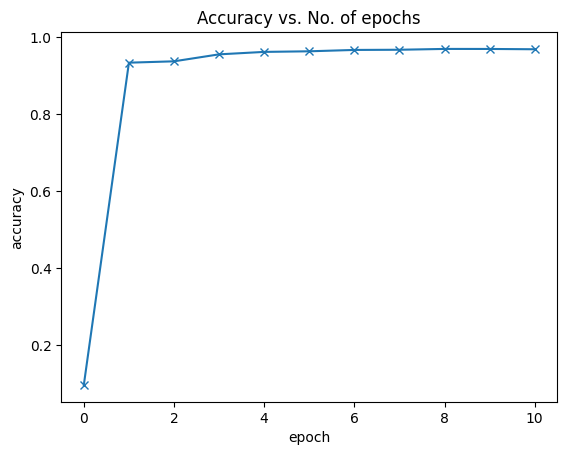

In [81]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

# Testing for viewing and predicting image

In [82]:
# test dataset
test_dataset = MNIST(
    root="data/",
    train=False,
    transform=ToTensor()
)

In [83]:
def predict_img(img, model):
    """
    img prediction function
    """
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1) # for each column point along the corresponding row
    return preds[0].item() # with preds[0] since unsqueeze(0)

In [91]:
def view_predict_img(dataset, img_index):
    """
    img plot and prediction
    """
    img, label = dataset[img_index]
    plt.imshow(img[0], cmap="gray")
    plt.show()
    print("Label: ", label, "predicted: ", predict_img(img, model))

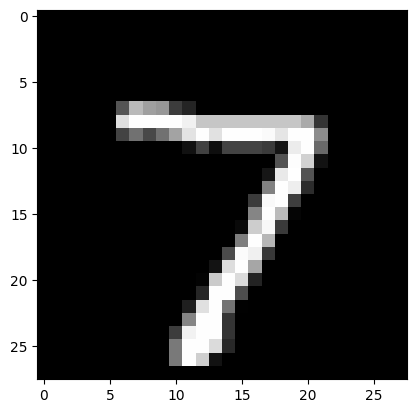

Label:  7 predicted:  7


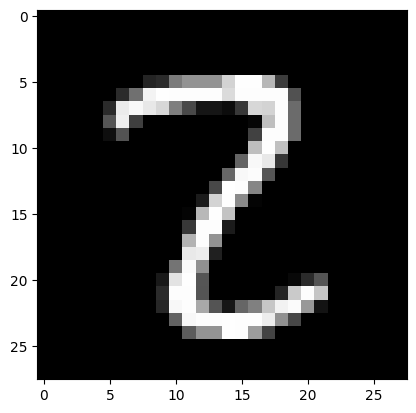

Label:  2 predicted:  2


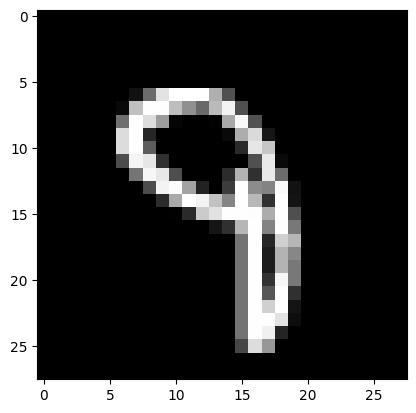

Label:  9 predicted:  9


In [92]:
for img_index in [0, 1839, 193]:
    view_predict_img(test_dataset, img_index)

# Overall loss and accuracy of the model on the test set

In [93]:
# train_loader and val_loader are at the 7th cell
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.10852978378534317, 'val_acc': 0.9681640863418579}